Выручка продукта несколько месяцев не растет, необходимо выяснить причины, выявить метрики для отслеживания, разработать несколько гипотез и выбрать одну из них, и реализовать ее 

In [1]:
from operator import attrgetter
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from datetime import timedelta

large = 22; med = 16; small = 12

params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)

plt.style.use('seaborn-whitegrid')
sns.set_style("white")

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')

In [3]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [4]:
items = pd.read_csv('olist_order_items_dataset.csv')

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Задача 1 

Оценить месячный retention в оформление заказа с помощью когортного анализа.

In [7]:

#объединение данных
data = orders.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')

# фильтрация только успешных заказов
data = data[data['order_status'] == 'delivered']

#преобразование даты
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# извлекаем месяц и день заказа
data['order_period'] = data['order_purchase_timestamp'].dt.to_period('M')
data['order_period_day'] = data['order_purchase_timestamp'].dt.to_period('D')

# присваиваем когорты на основе даты первого действия для каждого пользователя
data['cohort'] = data.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
data['cohort_day'] = data.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

# рассчитываем номер периода 
data['period_number_month'] = np.floor((data.order_period_day - data.cohort_day).apply(attrgetter('n')) / 30)

# создание когортной таблицы
cohorts = data.groupby(['cohort', 'period_number_month']) \
            .agg(n_customers=('customer_unique_id', 'nunique')) \
            .reset_index()

# таблица для retention
cohort_pivot = cohorts.pivot_table(
    index='cohort',
    columns='period_number_month',
    values='n_customers'
)

In [8]:
cohort_pivot

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,NaN,NaN,NaN
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
coh_size = cohort_pivot.iloc[:,0]

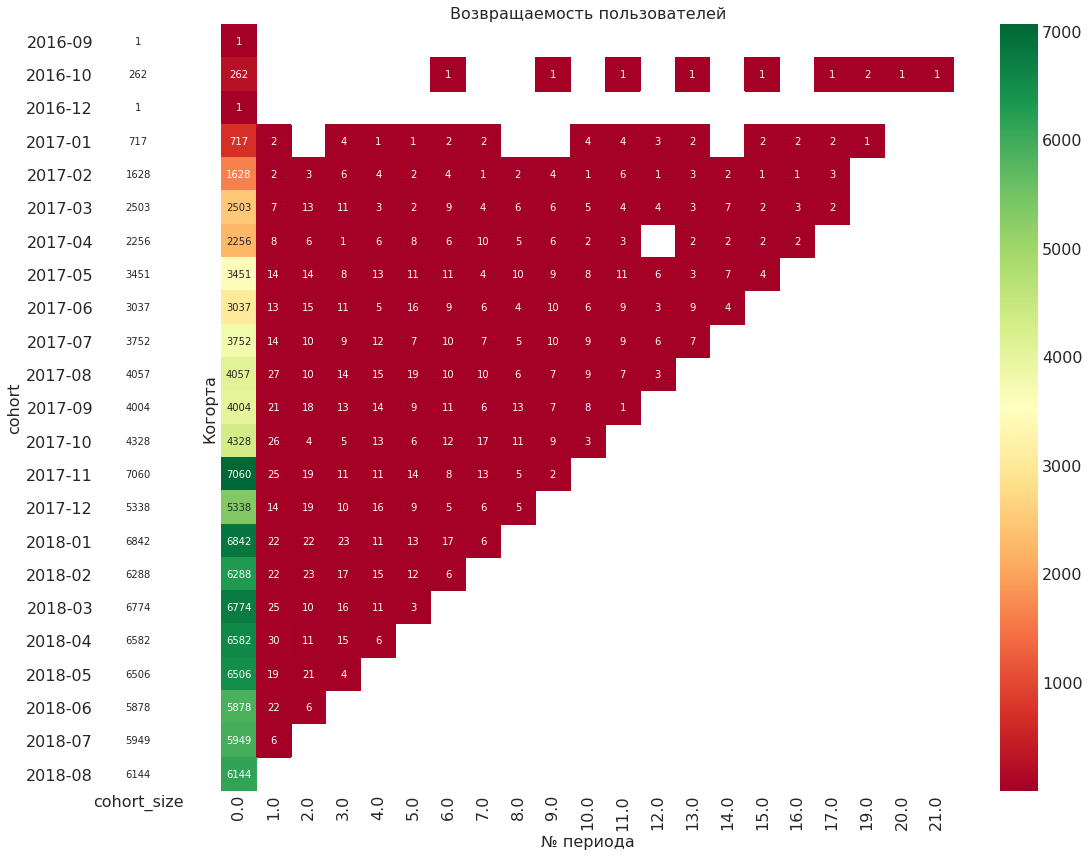

In [10]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    sns.heatmap(cohort_pivot,
                fmt='.0f',
                mask=cohort_pivot.isnull(),
                annot=True,
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Возвращаемость пользователей', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    cohort_size_df = pd.DataFrame(coh_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [11]:
retention = cohort_pivot.divide(coh_size, axis = 0)

In [12]:
retention

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN
2017-03,1.0,0.002797,0.005194,0.004395,0.001199,0.000799,0.003596,0.001598,0.002397,0.002397,...,0.001598,0.001598,0.001199,0.002797,0.000799,0.001199,0.000799,NaN,NaN,NaN
2017-04,1.0,0.003546,0.002660,0.000443,0.002660,0.003546,0.002660,0.004433,0.002216,0.002660,...,0.001330,NaN,0.000887,0.000887,0.000887,0.000887,NaN,NaN,NaN,NaN
2017-05,1.0,0.004057,0.004057,0.002318,0.003767,0.003187,0.003187,0.001159,0.002898,0.002608,...,0.003187,0.001739,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.004281,0.004939,0.003622,0.001646,0.005268,0.002963,0.001976,0.001317,0.003293,...,0.002963,0.000988,0.002963,0.001317,NaN,NaN,NaN,NaN,NaN,NaN


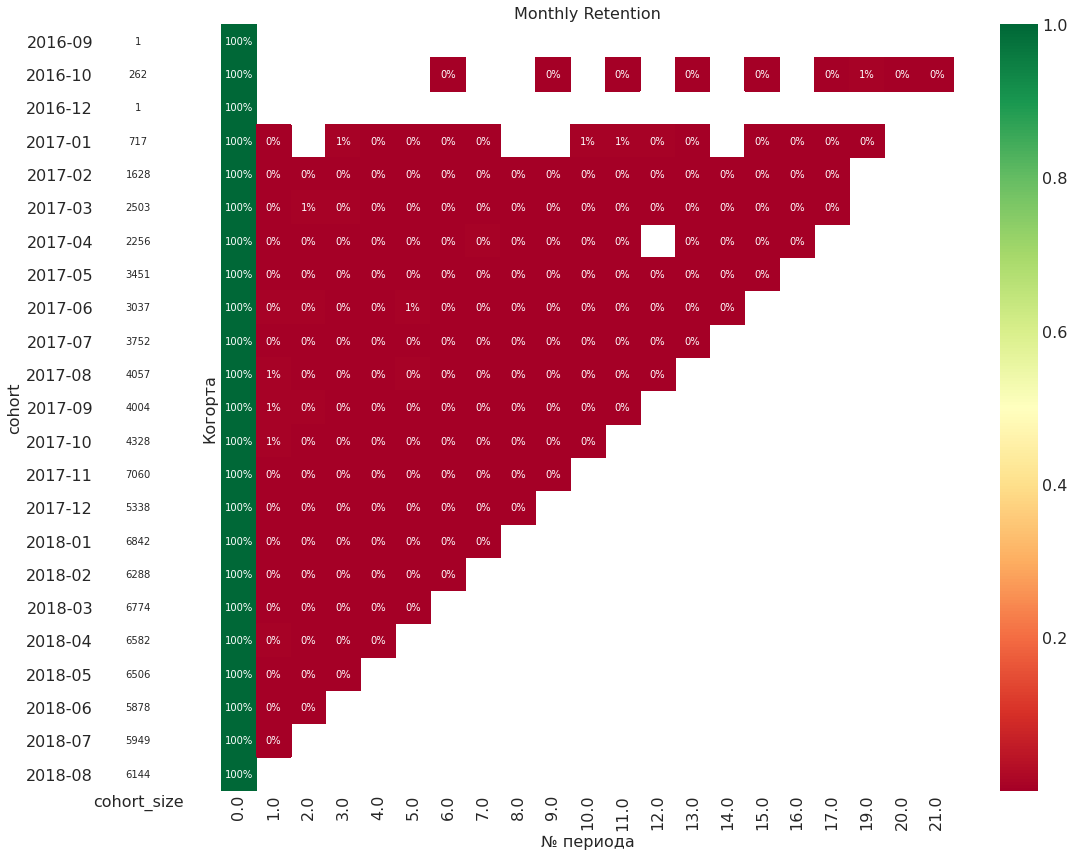

In [13]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # тепловая карта для коэффициентов удержания
    sns.heatmap(retention,
                mask=retention.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(coh_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [14]:
#медианый retention первого месяца
ret_1 = retention.iloc[:,1].median()

In [15]:
ret_1

0.0035460992907801418

In [16]:
# когорта с самым высоким retention на 3-й месяц.
retention.reset_index().iloc[retention.iloc[:,3].argmax(),0]

Period('2017-01', 'M')

Задача 2

Определить, существует ли product/market fit у маркетплейса.


Видно,что возвращаемость в продукт в районе нуля, а значит пользователь уходит от нас после первого же заказа, следовательно основная часть выручки приходится на новых пользователей. PMF отсутствует так как прродукт не удовлетворяет потребности пользователя. Необходимо выяснить с чем связано нежелание пользователя возвращаться в продукт.


Задача 3.

Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

Первая метрика должна отражать рост продаж маркетплейса

Обычно что это обьем продаж

In [17]:
#собираем данные о стоимости каждого заказа
price = items.groupby(['order_id'], as_index = False)['price'].sum()

In [18]:
sales = orders.merge(price, on = 'order_id', how = 'left')

In [19]:
sales['order_purchase_timestamp'] = pd.to_datetime(sales['order_purchase_timestamp'])

In [20]:
#разбиваем время заказов на периоды
sales['order_purchase_month'] = pd.to_datetime(sales['order_purchase_timestamp']).dt.to_period('M')

In [21]:
#собираем датасет с выручкой по месяцам...
sales_1 = sales.query('order_status == "delivered"').groupby(['order_purchase_month'], as_index = False).agg({'price':'sum', 'order_id':'count'})

''

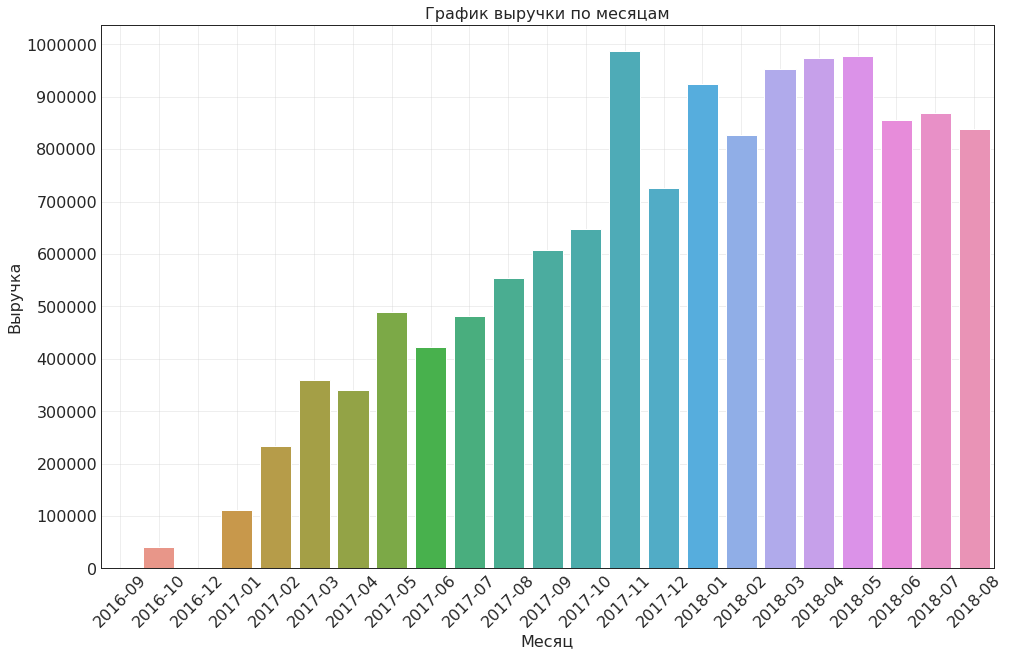

In [22]:
#... и строим по нему график
sns.barplot(data = sales_1, x = 'order_purchase_month', y = 'price')
plt.xticks(rotation = 45)
plt.yticks(np.linspace(0,1000000,11))
plt.ticklabel_format(style='plain',axis = 'y')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.title('График выручки по месяцам')
plt.grid(alpha = 0.4)
;

С начала года выручка не растет и вышла на плато

''

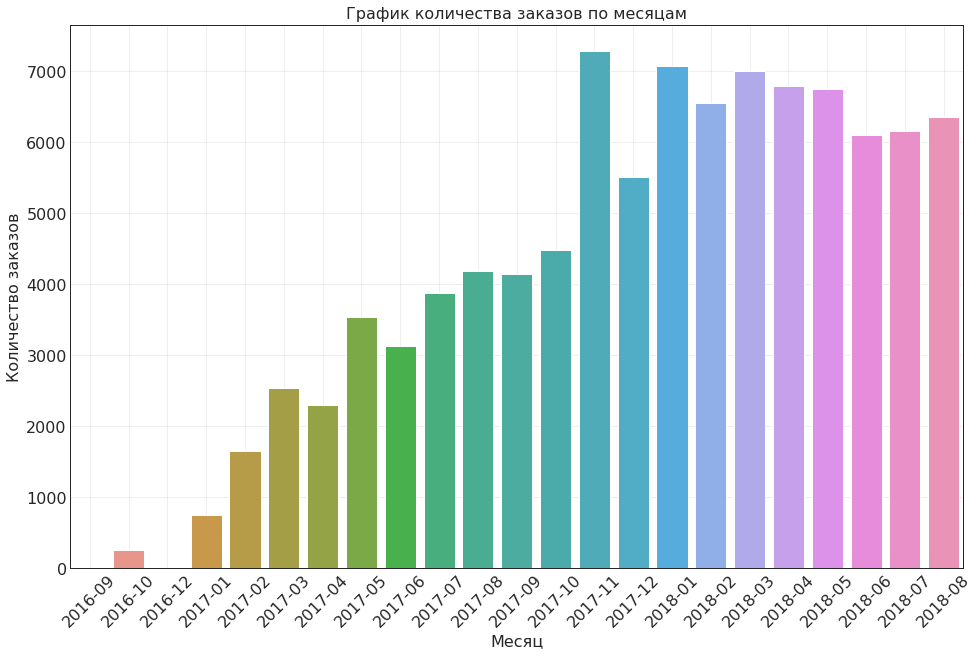

In [23]:
#а заодно и график обьема заказов
sns.barplot(data = sales_1, x = 'order_purchase_month', y = 'order_id')
plt.xticks(rotation = 45)
plt.ticklabel_format(style='plain',axis = 'y')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('График количества заказов по месяцам')
plt.grid(alpha = 0.4)
;

Вторая — показывать объем аудитории, которой продукт доставляет ценность.

Посчитаем уникальных активных пользователей, которые совершили хотя бы один заказ за период

In [24]:
#считаем покупателей по периодам в месяц
user1 = sales.query('order_status == "delivered"').merge(customers[['customer_unique_id','customer_id']], on = 'customer_id')\
.groupby(['order_purchase_month'], as_index = False)\
.agg({'customer_unique_id':'nunique'})

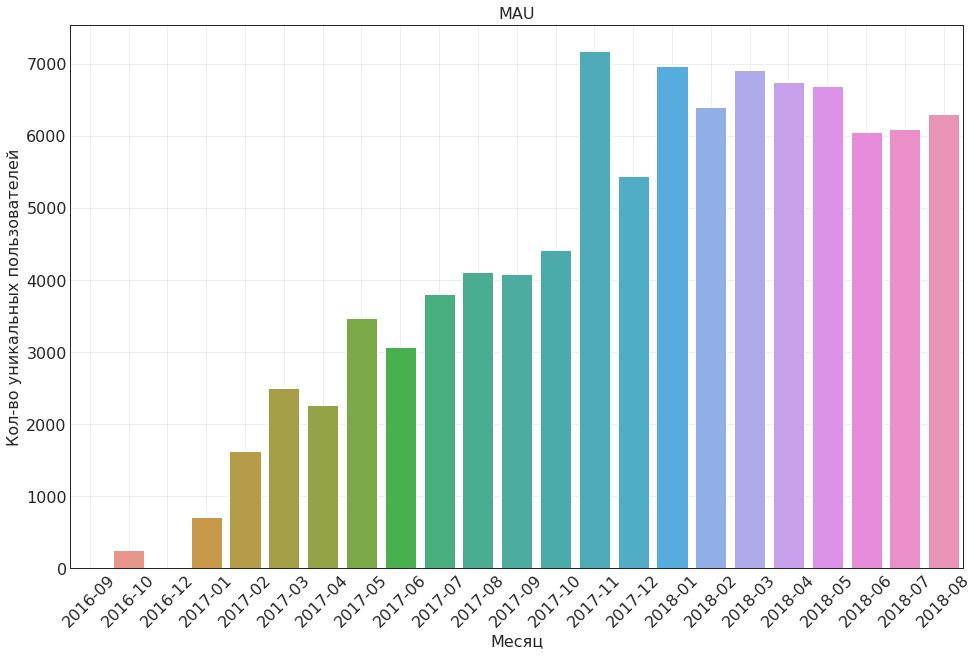

In [25]:
sns.barplot(data = user1, x = 'order_purchase_month', y = 'customer_unique_id')
plt.xticks(rotation = 45)
plt.ticklabel_format(style='plain',axis = 'y')
plt.xlabel('Месяц')
plt.ylabel('Кол-во уникальных пользователей')
plt.title('MAU')
plt.grid(alpha = 0.4)
plt.show()

Ежемесячная активность пользователей вышла на плато в тот же период

Третья — отражать заинтересованность новых клиентов в продакте.

Здесь мы возьмем количество новых пользователей, эта информация есть на тепловой карте в решении первой задачи

In [26]:
cohort_pivot.loc[:,0]

cohort
2016-09       1.0
2016-10     262.0
2016-12       1.0
2017-01     717.0
2017-02    1628.0
2017-03    2503.0
2017-04    2256.0
2017-05    3451.0
2017-06    3037.0
2017-07    3752.0
2017-08    4057.0
2017-09    4004.0
2017-10    4328.0
2017-11    7060.0
2017-12    5338.0
2018-01    6842.0
2018-02    6288.0
2018-03    6774.0
2018-04    6582.0
2018-05    6506.0
2018-06    5878.0
2018-07    5949.0
2018-08    6144.0
Freq: M, Name: 0.0, dtype: float64

При этом retention всегда на очень низком уровне, пользователи отказываются возвращаться в приложение, Почти вся выручка идет от новых пользователей количество которых прекратило расти, а за ними и прекратила расти выручка с продаж 

Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.

Возьмем коэфициент повторных покупок

In [27]:
s = sales.merge(customers, on = 'customer_id')

In [28]:
# подсчет всех пользователей и выборка тех кто совершил более одной покупки
s['count_purchase'] = s['customer_unique_id'].map(s['customer_unique_id'].value_counts())
s1 = s.loc[s['count_purchase']>1]

In [29]:
data = [s1.customer_unique_id.nunique(),s.customer_unique_id.nunique()]

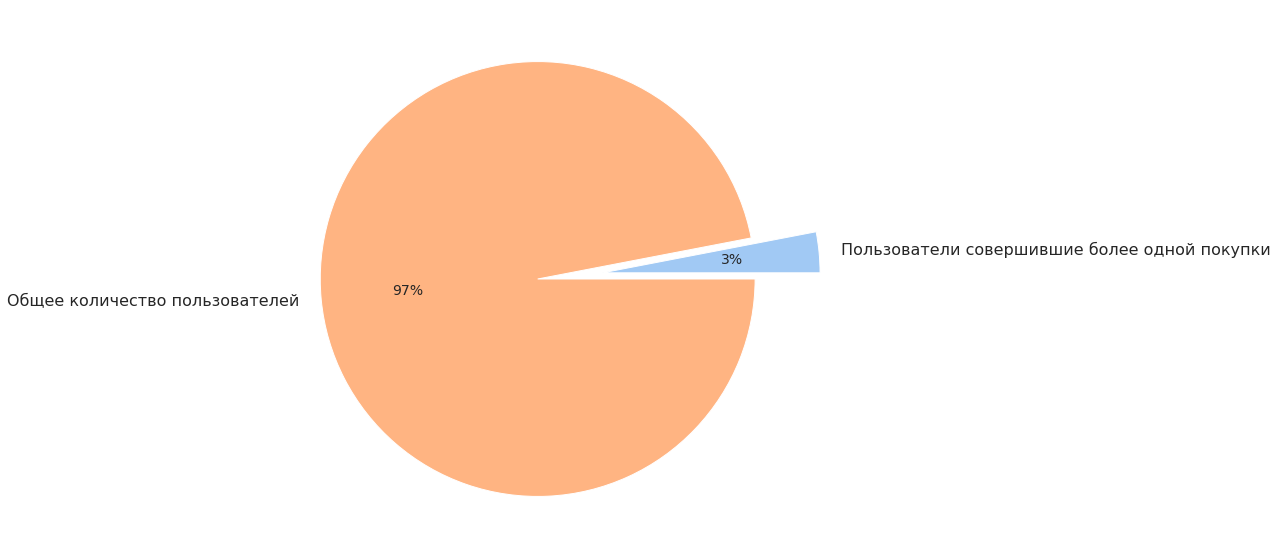

In [75]:
explode = [0.3,0]
plt.pie(data, labels = ['Пользователи совершившие более одной покупки',
                      'Общее количество пользователей'],
      explode = explode, autopct = '%.0f%%',
      colors = sns.color_palette('pastel'))
mpl.rc('font', size = 14)
plt.show()

Пятая — отражать денежное выражение вовлеченности клиента.

Это средний чек

In [31]:
#считаем арппу = выручка / количество уникальных пользователей
user1['ARPPU'] = sales_1['price']/user1['customer_unique_id']

''

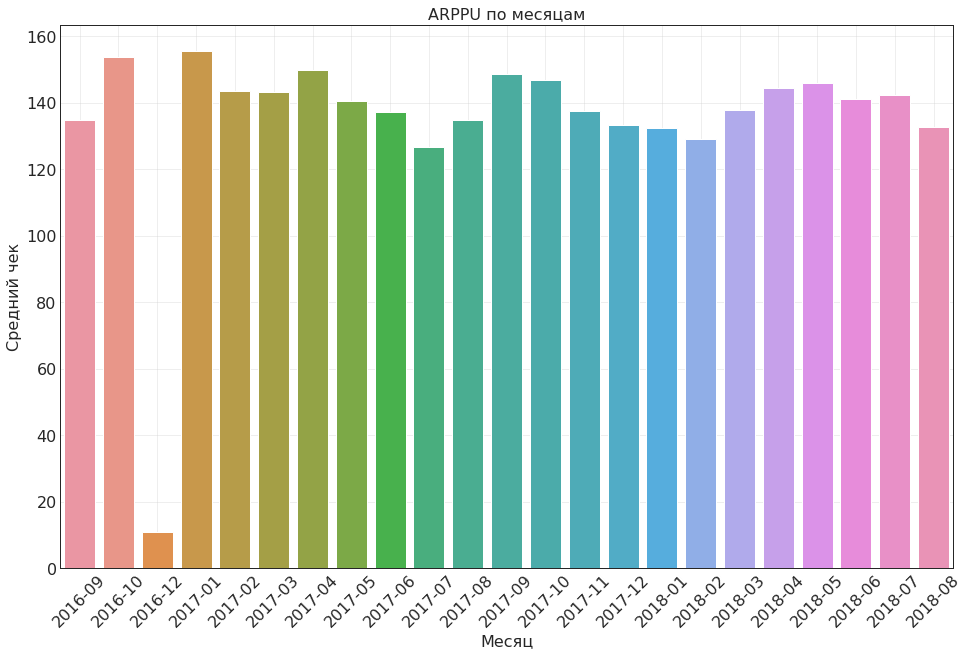

In [32]:
sns.barplot(data = user1, x = 'order_purchase_month', y = 'ARPPU')
plt.xticks(rotation = 45)
plt.ticklabel_format(style='plain',axis = 'y')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.title('ARPPU по месяцам')
plt.grid(alpha = 0.4)
;

ARPPU держится примерно на одном уровне за все время жизни продукта

Из полученных данных выясняется, что основная часть выручки продукта зависит от новых пользователей, приток которых вышел на плато и, соответсвенно, на плато вышла и выручка с обьемом заказов. Возможно, если мы сможем вернуть часть клиентов это позволит повысить общий обьем продаж и меньше зависеть от колебаний притока новых пользователей

Задача 4 

Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

In [33]:
all_sales = orders.merge(customers, on = 'customer_id')

In [34]:
all_sales['order_purchase_timestamp'] = pd.to_datetime(all_sales['order_purchase_timestamp'])
all_sales['order_delivered_carrier_date'] = pd.to_datetime(all_sales['order_delivered_carrier_date'])
all_sales['order_delivered_customer_date'] = pd.to_datetime(all_sales['order_delivered_customer_date'])
all_sales['order_estimated_delivery_date'] = pd.to_datetime(all_sales['order_estimated_delivery_date'])
all_sales['order_approved_at'] = pd.to_datetime(all_sales['order_approved_at'])

In [35]:
all_sales = all_sales[all_sales['order_purchase_timestamp'] >= '2017-06-01']

In [36]:
user_count = all_sales.query("order_status == 'delivered'").customer_unique_id.nunique()

In [37]:
def calculate_impact(metric_value):
    """
    Присваивает оценку Impact на основе значения метрики по заданной шкале.
    
    """
    ranges = [
        (0, 50, 1),
        (51, 150, 2),
        (151, 350, 3),
        (351, 750, 4),
        (751, 1550, 5),
        (1551, 3150, 6),
        (3151, 6350, 7),
        (6351, 12750, 8),
        (12751, 25550, 9),
        (25551, 51150, 10)
    ]
    
    for lower, upper, impact in ranges:
        if lower <= metric_value <= upper:
            return impact

Гипотеза 1

Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится.

In [38]:
#общее количество отмененных заказов
canc = all_sales[all_sales['order_status'] == 'canceled']['order_id'].count()

In [39]:
#доля отмененных заказов
canc/all_sales.order_id.count()

0.0056868689171016345

In [40]:
canc

499

Но, что если заказы были отменены в результате задваивания заказа и пользователь уже получил свой заказ? Посчитаем таких пользователей

In [41]:
# фильтрация отмененных заказов
canceled_orders = all_sales[all_sales['order_status'] == 'canceled']

# группировка по пользователям и дате отмены
canceled_orders_grouped = canceled_orders.groupby(['customer_unique_id', canceled_orders['order_purchase_timestamp'].dt.date])

# список для хранения отфильтрованных строк
filtered_data = []

# перебор групп отмененных заказов
for (user_id, cancel_date), group in canceled_orders_grouped:
    # фильтрация всех заказов пользователя в тот же день
    user_orders_same_day = all_sales[(all_sales['customer_unique_id'] == user_id) & 
                                (all_sales['order_purchase_timestamp'].dt.date == cancel_date)]
    
    #если есть хотя бы один заказ после отмены
    if len(user_orders_same_day[user_orders_same_day['order_status'] != 'canceled']) > 0:
        # добавляем все заказы пользователя за этот день в результат
        filtered_data.append(user_orders_same_day)

#объединение всех отфильтрованных строк в один DataFrame
if filtered_data:
    result = pd.concat(filtered_data)
else:
    result = pd.DataFrame(columns=all_sales.columns)  # если нет данных, возвращаем пустой DataFrame

In [42]:
#получим приблизительное число заказов которые были задублированы
#(приблизительно потому что возможны затраивание заказа и больше)
result.customer_unique_id.nunique()

19

In [76]:
#количество заказов которые не были продублированы успешным в короткий промежуток времени
cancel =  canc - result.customer_unique_id.nunique()
print(cancel)

480


In [77]:
Impact_1 = calculate_impact(cancel)
Confidence_1 = 8
Ease_1 = 6
ICE_1 = Impact_1*Confidence_1*Ease_1
print(ICE_1)

192


Гипотеза 2 

Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов.

Попробуем взять разделить по среднему количеству дней передачи в доставку

In [121]:
orders_flow = all_sales[~all_sales['order_delivered_customer_date'].isna()]

In [122]:
orders_flow = orders_flow[orders_flow.order_status == 'delivered']

In [123]:
#расчет времени передачи в логистическую службу
orders_flow['time_to_carrier'] = (orders_flow['order_delivered_carrier_date'] - orders_flow['order_purchase_timestamp']).dt.days

In [124]:
orders_flow['time_to_carrier']

0        2.0
1        1.0
2        0.0
3        3.0
4        0.0
        ... 
99433    0.0
99437    1.0
99438    1.0
99439    3.0
99440    1.0
Name: time_to_carrier, Length: 85406, dtype: float64

In [125]:
#среднее время передачи
med_time = orders_flow['time_to_carrier'].mean()

In [126]:
med_time

2.703296059949652

In [127]:
# Разделение на две группы
group_1 = orders_flow[orders_flow['time_to_carrier'] < med_time]  # меньше среднего
group_2 = orders_flow[orders_flow['time_to_carrier'] >= med_time]  #больше или равно среднему

In [128]:
# Расчет повторных заказов для каждой группы
def repeat_user(group):
    repeat_users = group[group\
                .customer_unique_id\
                .map(group['customer_unique_id']\
                     .value_counts()) >1]\
    .customer_unique_id.nunique()
    return repeat_users

In [129]:
repeat_1 = repeat_user(group_1)
repeat_2 = repeat_user(group_2)

In [130]:
# oбщее количество пользователей в каждой группе
total_1 = group_1['customer_unique_id'].nunique()
total_2 = group_2['customer_unique_id'].nunique()

In [131]:
# конверсия в повторный заказ
conversion_1 = repeat_1 / total_1
conversion_2 = repeat_2 / total_2

In [132]:
print(f"Конверсия в повторный заказ (группа 1): {conversion_1}")
print(f"Конверсия в повторный заказ (группа 2): {conversion_2}")

Конверсия в повторный заказ (группа 1): 0.019347341919240826
Конверсия в повторный заказ (группа 2): 0.01617770587686277


In [133]:
#находим разницу между новой конверсией и старой
profit = round(user_count*conversion_1 - user_count * ret_1)

In [134]:
profit

1309

In [135]:
impact_2 = calculate_impact(profit)

In [136]:
Confidence_2 = 10
Ease_2 = 4
ICE_2 = impact_2*Confidence_2*Ease_2
print(ICE_2)

200


Гипотеза 3

Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

Cкорее всего уменьшится время до подтверждения оплаты, будем исходить из этого в анализе

In [137]:
#чистим данные 
all_sales_del = all_sales[~all_sales['order_delivered_customer_date'].isna()]

In [138]:
all_sales_del = all_sales_del.loc[all_sales_del.order_status == 'delivered']

In [139]:
#подсчитаем время от создания заказ до подтверждения оплаты
all_sales_del['purch_time'] = (all_sales_del['order_approved_at'] - all_sales_del['order_purchase_timestamp']).dt.seconds

In [140]:
med_time_purch = all_sales_del['purch_time'].mean()

In [141]:
med_time_purch

14464.764302273845

In [142]:
#те у кого время подтверждения выше среднего
long_pay = all_sales_del[all_sales_del['purch_time'] > med_time_purch]

In [143]:
#те у кого меньше среднего
fast_pay = all_sales_del[all_sales_del['purch_time'] <= med_time_purch]

In [144]:
#коэф повторного заказа у долгой группы
long = repeat_user(long_pay)/long_pay.customer_unique_id.nunique()
print(long)

0.01887050458088336


In [145]:
#коэф повторного заказа у быстрой группы
fast = repeat_user(fast_pay)/fast_pay.customer_unique_id.nunique()
print(fast)

0.02571633705371712


In [146]:
impact_3 = calculate_impact(user_count*fast - user_count*ret_1)

In [147]:
confidence_3 = 5
ease_3 = 9
ICE_3 = impact_3*ease_3*confidence_3
print(ICE_3)

270


У тех пользователей которые меньше ждали подтверждения оплаты коэфициент возврата несколько выше, возможно введение нового способа оплаты позволит сократить это время и улучшить пользовательский опыт


Задача 5

Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

1. Целевые метрики:


Конверсия в повторный заказ

Доля клиентов, совершивших больше 1 заказа за выбранный период.

(Количество клиентов с повторными заказами) / (Общее количество уникальных клиентов) * 100%.

Зачем: Показывает, насколько новый способ оплаты стимулирует клиентов возвращаться.

2. Прокси-метрики:


Снижение времени оформления заказа

Среднее время от добавления товара в корзину до завершения оплаты.

Зачем: Упрощение оплаты должно сократить время оформления, что возможно улучшит пользовательский опыт.



Уровень отказов на этапе оплаты (Cart Abandonment Rate)

Процент клиентов, которые начали оформление заказа, но не завершили оплату.

Зачем: Если новый способ удобен, уровень отказов снизится.

3. Guardrail-метрики:


Средний чек

Средняя сумма заказа на одного клиента.

Зачем: Убедиться, что упрощение оплаты не привело к снижению среднего чека.


Количество обращений в поддержку по оплате

Число жалоб, связанных с оплатой.

Зачем: Новый способ не должен создавать технических проблем или путаницы.